# Final Project A: Environment Sensor

### Group 65 Members: Kyra Ballard, Lauren Baker, Kaela Nelson

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

### Functions

In [2]:
def read_txt(filename):
    """
    A function that opens text files and appends to list.
    
    Inputs:
        filename: files to load
    Outputs:
        save_ls: list of files 
    """
    
    save_ls = []
    with open(filename, 'r') as file:
        for line in file:
            line = line.split(',')
            for val in line:
                save_ls.append(val)
                
    return save_ls

In [3]:
def load_data(path):
    """
    A function that loads text files using read_text function and 
    changes list of entries to floats.
    
    Inputs:
        path: files to open
    Outputs:
        data: list of data as floats
    """
    
    data = read_txt(path)
    data = [float(data[i]) for i in range(len(data)-1)]
    
    return data

In [4]:
def create_timestamp(data, collection_freq, start_year, start_month, start_day, start_hour, start_min):
    
    """
    A function that creates timestamps for each data entry
    based on start time and collection frequency.
    
    Inputs:
        data: list of data values
        collection_freq: user-set frequency
        start_year: year sensor was started (i.e. 2019
        start_month: month number was started (i.e. 10 = Oct)
        start_day: number day sensor was started
        start_hour: hour of day sensor was started
        start_min: minute of day sensor was started
    Outputs:
        dates: timestamp object for each data entry
    """
    
    start_date = datetime.datetime(start_year, start_month, start_day, hour=start_hour, minute=start_min)
    dates = [start_date]
    
    for i in range(len(data)-1): 
        dates.append(dates[i] + datetime.timedelta(minutes=collection_freq))
    
    return dates

In [5]:
def build_df(dates_list, data_list, data_name):
    
    """
    A function that combines data from all collections 
    into single dataframe.
    
    Inputs:
        dates_list: list of all collection dates
        data_list: list of all collection data
        data_name: string (i.e. light, pressure)

    Outputs:
        df: dataframe with data values and corresponding timestamps
    """
    
    df = pd.DataFrame()
    
    for i in range(len(data_list)):
        df_temp = pd.DataFrame({'date': dates_list[i], data_name : data_list[i]})
        df = df.append(df_temp, ignore_index = True)
        
    return df

In [6]:
def find_rows(df, time_of_interest, time_str):
    
    """
    A function that finds rows of dataframe corresponding
    to the time period of interest, i.e. day or hour.
    
    Inputs:
        df: dataframe 
        time of interest: time component of df.dates (i.e. day or hour)
        time_str: 'hour' or 'day'

    Outputs:
        rows: rows of dataframe for given time
    """
    
    rows_Oct = []
    rows_Nov = []
    rows_Dec = []
    
    if time_str == 'day':
        for i,dt in enumerate(df.date):
            if dt.month == 10:
                if dt.day == time_of_interest:
                    rows_Oct.append(i)
            elif dt.month == 11:
                if dt.day == time_of_interest:
                    rows_Nov.append(i)
            else:
                if dt.day == time_of_interest:
                    rows_Dec.append(i)

    else: 
        for i,dt in enumerate(df.date):
            if dt.month == 10:
                if dt.hour == time_of_interest:
                    rows_Oct.append(i)
            elif dt.month == 11:
                if dt.hour == time_of_interest:
                    rows_Nov.append(i)
            else:
                if dt.hour == time_of_interest:
                    rows_Dec.append(i)
                    
    rows = [rows_Oct, rows_Nov, rows_Dec]
    
    return rows

In [7]:
def find_time_indices(df, time_str):
    
    """
    A function that finds indices of dataframe corresponding
    to the time period of interest, i.e. day or hour.
    
    Inputs:
        df: dataframe 
        time_str: 'hour' or 'day'

    Outputs:
        times: list of times
        indices_of_times: list of indices
    """
    
    times_Oct = []
    times_Nov = []
    times_Dec = []
    
    indices_of_times_Oct = []
    indices_of_times_Nov = []
    indices_of_times_Dec = []
    
    # Days
    
    if time_str == 'day':
        
        for dt in df.date:
            
            if dt.month == 10:
                times_Oct.append(dt.day)
                
            elif dt.month == 11:
                times_Nov.append(dt.day)
            
            else:
                times_Dec.append(dt.day)
            
        times_Oct = np.unique(times_Oct)
        times_Nov = np.unique(times_Nov)
        times_Dec = np.unique(times_Dec)

        for time in times_Oct:
            indices_of_times_Oct.append(find_rows(df, time, 'day')[0])
        for time in times_Nov:
            indices_of_times_Nov.append(find_rows(df, time, 'day')[1])
        for time in times_Dec:
            indices_of_times_Dec.append(find_rows(df, time, 'day')[2])
        
    # Hours
    
    else:
        
        for dt in df.date:
            if dt.month == 10:
                times_Oct.append(dt.hour)
                
            elif dt.month == 11:
                times_Nov.append(dt.hour)
            
            else:
                times_Dec.append(dt.hour)
            
        times_Oct = np.unique(times_Oct)
        times_Nov = np.unique(times_Nov)
        times_Dec = np.unique(times_Dec)
        
        for time in times_Oct:
            indices_of_times_Oct.append(find_rows(df, time, 'hour')[0])
        for time in times_Nov:
            indices_of_times_Nov.append(find_rows(df, time, 'hour')[1])
        for time in times_Dec:
            indices_of_times_Dec.append(find_rows(df, time, 'hour')[2])
            
    times = [times_Oct, times_Nov, times_Dec]
    indices_of_times = [indices_of_times_Oct, indices_of_times_Nov, indices_of_times_Dec]

    return times, indices_of_times

In [8]:
def plot_days(df, data_name, rows, label):
    
    """
    A function that plots data value vs. hour of day
    for each day collected.
    
    Inputs:
        df: dataframe 
        data_name: string of data category (i.e. 'light', 'pressure')
        rows: from find_rows
        label: string of day (i.e. 'Nov1st')

    Outputs:
        plot
    """
    
    # Create x axis based on hour of day
    x_plot = []
    for i in range(df.shape[0]):
        x_vals = df.date[i].hour + df.date[i].minute/60
        x_plot.append(x_vals)
        
    # Plot hour of day vs. data value
    plt.scatter(x_plot[rows[0]:rows[0]+len(rows)], df[data_name].values[rows],  
                label = label, alpha = 0.5, cmap = 'RdPu')

    # Label plot
    plt.xlabel('Hour of Day', fontsize = 20)
    plt.ylabel('Data Value', fontsize = 20)
    plt.legend()
    
    return 

In [9]:
def classify(df, sunrise, sunset):
    
    """
    A function that classifies "light on" data values as 
    "natural" light (0) or "artificial" light(1) based on 
    whether the sun has risen or set (times determined 
    empirically from averaged data).
    
    Inputs:
        df: dataframe 
        sunrise: sunrise hour
        sunset: sunset hour

    Outputs:
        y: list of 1's and 0's
    """
    
    y = []
    for sample in range(df.shape[0]):
        
        if sunrise < df.loc[sample,'hour'] < sunset:
            y.append(1) #natural
            
        elif df.loc[sample,'light_on'] == 1:
            y.append(2) # artificial 
            
        else:
            y.append(0)
            
    return y

## Visualizing Sensor Data: Light

In [11]:
data_name = 'temperature'
collection_freq0 = 30 # mins
collection_freq = 10 # mins

In [12]:
# Load data
data_1 = load_data('data_1\CS109a_temperature.txt')
data_2 = load_data('data_2\CS109a_temperature.txt')
data_3 = load_data('data_3\CS109a_temperature.txt')
data_4 = load_data('data_4\CS109a_temperature.txt')
data_5 = load_data('data_5\CS109a_temperature.txt')
data_6 = load_data('data_6\CS109a_temperature.txt')
data_7 = load_data('data_7\CS109a_temperature.txt')
data_8 = load_data('data_8\CS109a_temperature.txt')
data_9 = load_data('data_9\CS109a_temperature.txt')
data_10 = load_data('data_10\CS109a_temperature.txt')
data_11 = load_data('data_11\CS109a_temperature.txt')

data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10, data_11] 

# Check data length
for i in range(len(data_list)):
    print(len(data_list[i]))

96
96
48
288
432
432
432
432
432
432
432


In [15]:
# Create timestamp for each 
dates_1 = create_timestamp(data_1, collection_freq0, 2019, 10, 29, 22, 36)
dates_2 = create_timestamp(data_2, collection_freq0, 2019, 11, 1, 9, 14)
dates_3 = create_timestamp(data_3, collection_freq0, 2019, 11, 6, 20, 15)
dates_4 = create_timestamp(data_4, collection_freq, 2019, 11, 8, 9, 5)
dates_5 = create_timestamp(data_5, collection_freq, 2019, 11, 10, 13, 51)
dates_6 = create_timestamp(data_6, collection_freq, 2019, 11, 13, 18, 45)
dates_7 = create_timestamp(data_7, collection_freq, 2019, 11, 16, 20, 56)
dates_8 = create_timestamp(data_8, collection_freq, 2019, 11, 19, 21, 57) 
dates_9 = create_timestamp(data_9, collection_freq, 2019, 11, 26, 19, 42)
dates_10 = create_timestamp(data_10, collection_freq, 2019, 11, 29, 23, 1)
dates_11 = create_timestamp(data_11, collection_freq, 2019, 12, 2, 23, 22)

# Build dataframe of all collections
dates_list = [dates_1, dates_2, dates_3, dates_4, dates_5, dates_6, dates_7, dates_8, dates_9, dates_10, dates_11] 
data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10, data_11] 

df = build_df(dates_list, data_list, data_name)
df.head()

,date,temperature
0,2019-10-29 22:36:00,22.8
1,2019-10-29 23:06:00,22.8
2,2019-10-29 23:36:00,22.5
3,2019-10-30 00:06:00,22.4
4,2019-10-30 00:36:00,22.3


In [16]:
# Group data by hour and day
hours, indices_of_hours = find_time_indices(df, 'hour')
days, indices_of_days = find_time_indices(df, 'day')

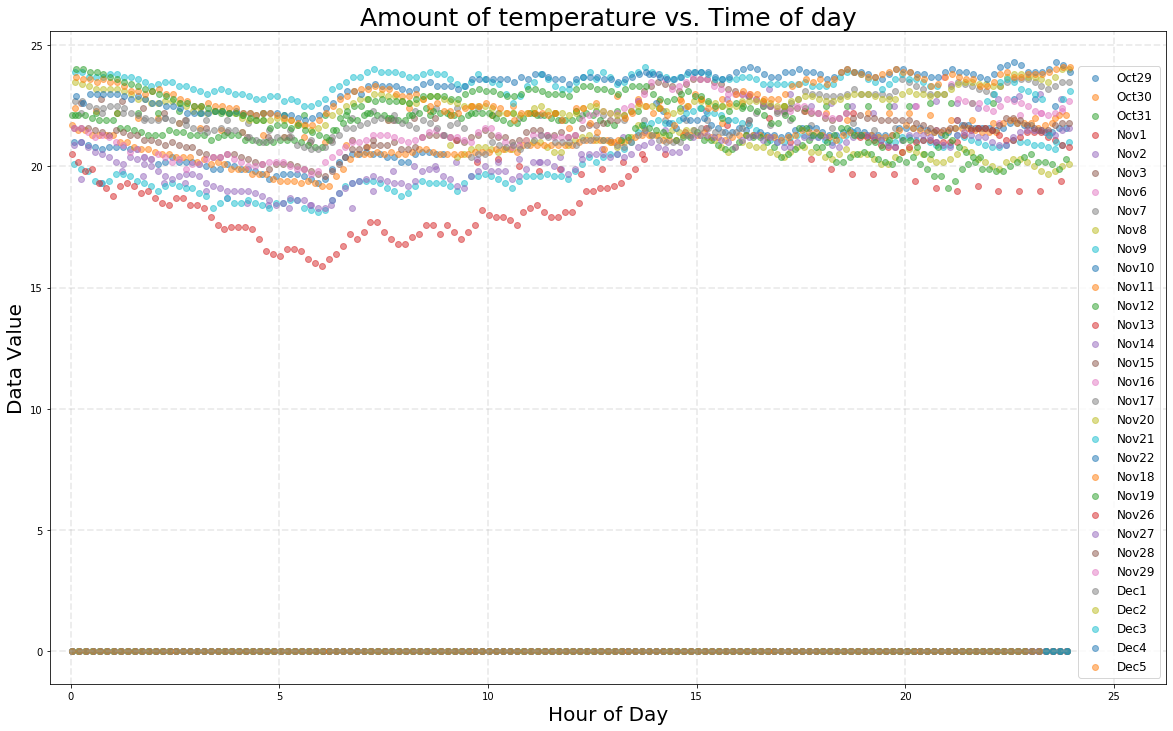

In [17]:
# Plot light data per hour per day   
plt.subplots(figsize = (20,12))

calendar_day_Oct = ['Oct29', 'Oct30','Oct31']
calendar_day_Nov = ['Nov1','Nov2','Nov3','Nov6','Nov7','Nov8','Nov9','Nov10',
                    'Nov11','Nov12','Nov13','Nov14','Nov15', 'Nov16','Nov17',
                    'Nov20','Nov21','Nov22','Nov18','Nov19','Nov26','Nov27',
                    'Nov28','Nov29']
calendar_day_Dec = ['Dec1','Dec2','Dec3','Dec4','Dec5']

for i in range(len(calendar_day_Oct)):
    plot_days(df, data_name, indices_of_days[0][i], calendar_day_Oct[i])
for i in range(len(calendar_day_Nov)):
    plot_days(df, data_name, indices_of_days[1][i], calendar_day_Nov[i])    
for i in range(len(calendar_day_Dec)):
    plot_days(df, data_name, indices_of_days[2][i], calendar_day_Dec[i])

plt.title('Amount of {} vs. Time of day'.format(data_name), fontsize = 25)
# plt.plot(hours[0], ave_data_per_hr, '-or', markersize = 12, linewidth = 3, label = 'avg')
plt.legend(loc = 'lower right', fontsize = 12)
plt.xlim([-0.5,26.25])
plt.grid(True, lw=1.75, ls='--', alpha=0.25)
plt.show()

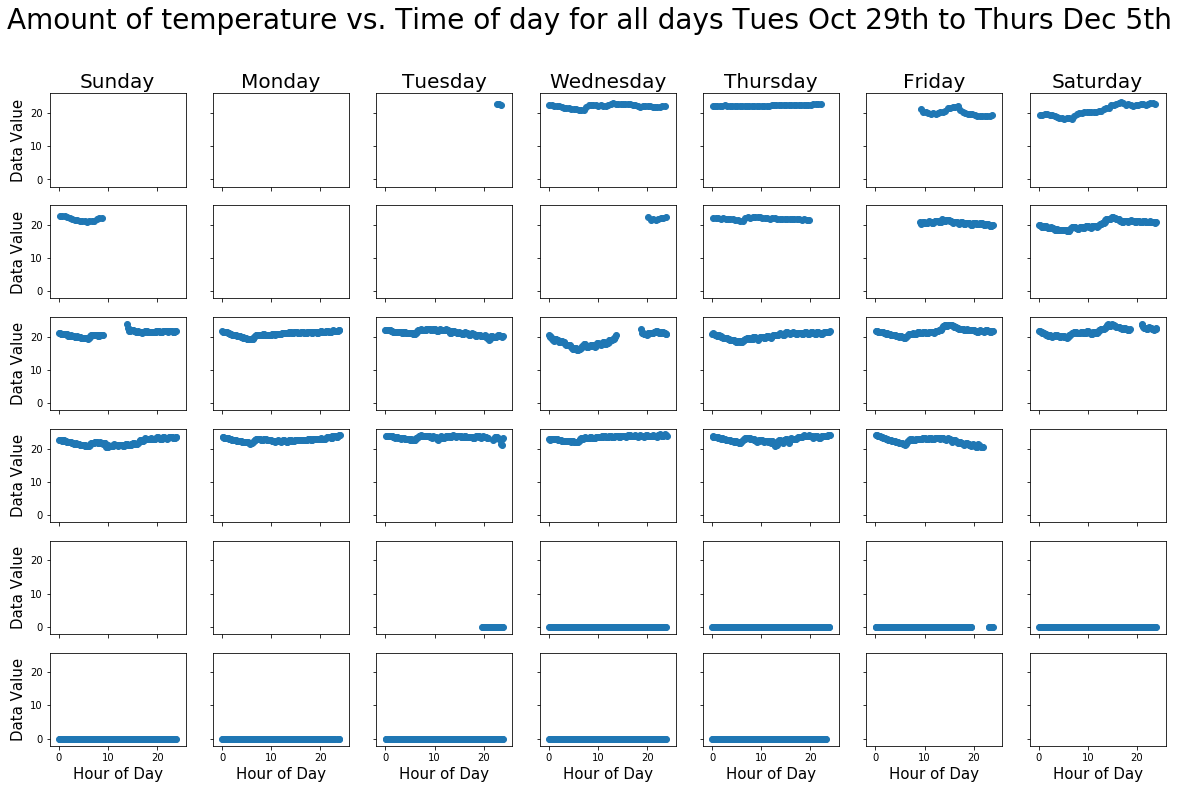

In [18]:
fig, ax = plt.subplots(6,7, figsize = (20,12), sharex=True, sharey=True)

# 'X' data
x_plot = []
for i in range(df.shape[0]):
    x_vals = df.date[i].hour + df.date[i].minute/60
    x_plot.append(x_vals)

# 'Y' data
data_days = []
for i in range(len(days[0])):
    data_by_day_Oct = df[data_name].values[indices_of_days[0][i]]
    data_days.append(data_by_day_Oct)
for i in range(len(days[1])):
    data_by_day_Nov = df[data_name].values[indices_of_days[1][i]]
    data_days.append(data_by_day_Nov)
for i in range(len(days[2])):
    data_by_day_Dec = df[data_name].values[indices_of_days[2][i]]
    data_days.append(data_by_day_Dec)

# Plot in calendar form
for i in range(28):
    if i < 3:
        ax[0,i+2].scatter(x_plot[indices_of_days[0][i][0]:indices_of_days[0][i][0]
                                 + len(indices_of_days[0][i])], data_days[i]) 
    elif 3 <= i < 5:
        ax[0,i+2].scatter(x_plot[indices_of_days[1][i-3][0]:indices_of_days[1][i-3][0]
                                 + len(indices_of_days[1][i-3])], data_days[i])
    elif i == 5:
        ax[1,0].scatter(x_plot[indices_of_days[1][i-3][0]:indices_of_days[1][i-3][0]
                               + len(indices_of_days[1][i-3])], data_days[i])
    elif 6 <= i < 10:
        ax[1,i-3].scatter(x_plot[indices_of_days[1][i-3][0]:indices_of_days[1][i-3][0]
                                 + len(indices_of_days[1][i-3])], data_days[i])
    elif 10 <= i < 17:
        ax[2,i-10].scatter(x_plot[indices_of_days[1][i-3][0]:indices_of_days[1][i-3][0]
                                  + len(indices_of_days[1][i-3])], data_days[i])                        
    elif 17 <= i < 23:
        ax[3,i-17].scatter(x_plot[indices_of_days[1][i-3][0]:indices_of_days[1][i-3][0]
                                  + len(indices_of_days[1][i-3])], data_days[i])
    else:
        ax[4,i-21].scatter(x_plot[indices_of_days[1][i-3][0]:indices_of_days[1][i-3][0] 
                                  + len(indices_of_days[1][i-3])], data_days[i]) 
        
        
ax[5,0].scatter(x_plot[indices_of_days[2][0][0]:indices_of_days[2][0][0] + len(indices_of_days[2][0])], 
                           data_days[-5])
ax[5,1].scatter(x_plot[indices_of_days[2][1][0]:indices_of_days[2][1][0] + len(indices_of_days[2][1])], 
                           data_days[-4])
ax[5,2].scatter(x_plot[indices_of_days[2][2][0]:indices_of_days[2][2][0] + len(indices_of_days[2][2])], 
                           data_days[-3])
ax[5,3].scatter(x_plot[indices_of_days[2][3][0]:indices_of_days[2][3][0] + len(indices_of_days[2][3])], 
                           data_days[-2])
ax[5,4].scatter(x_plot[indices_of_days[2][4][0]:indices_of_days[2][4][0] + len(indices_of_days[2][4])], 
                           data_days[-1])

# Label
days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

for i in range(0,7):
    ax[0,i].set_title(days_of_week[i], fontsize = 20)
    ax[5,i].set_xlabel('Hour of Day', fontsize = 15)
    
for i in range(0,6):
    ax[i,0].set_ylabel('Data Value', fontsize = 15)
    
fig.suptitle('Amount of {} vs. Time of day for all days Tues Oct 29th to Thurs Dec 5th'.format(data_name), 
             fontsize = 28)
plt.show()